In [1]:
import pymolpro
import random
import numpy as np
import pandas as pd
import os
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
#unused
def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False

#builds n**3,n**3 array of distance reciprocals
def distances(o1,o2):
    big_arr=np.empty((0,n**3))
    for i in range(len(grid_dt[o1])):
        tmp_list=[]
        for j in range(len(grid_dt[o2])):
            #find the distance
            o1x,o1y,o1z = grid_dt[o1][i]['x'], grid_dt[o1][i]['y'],grid_dt[o1][i]['z']
            o2x,o2y,o2z = grid_dt[o2][j]['x'], grid_dt[o2][j]['y'],grid_dt[o2][j]['z']
            r=math.sqrt((o1x-o2x)**2+(o1y-o2y)**2+(o1z-o2z)**2)
            #correlation energy should scale like r^-6 so take the reciprocal, going to lead to problems at 0 so take an error function
            if r==0:
                w=1
            else:   
                w=(math.erf(a*r)/r)**6
            tmp_list.append(float(w))
        tmp_arr=np.array(tmp_list)
        tmp_arr.reshape((1,len(tmp_list)))
        big_arr=np.vstack((big_arr,tmp_arr))
    
    return big_arr

def centdist(oid1,oid2):
    if chkorbid(oid1,oid2)==True:
        return 1
    else:
        r=(math.sqrt((cent_dt[oid1]['x']-cent_dt[oid2]['x'])**2+
        ((cent_dt[oid1]['y']-cent_dt[oid2]['x'])**2)+
        ((cent_dt[oid1]['z']-cent_dt[oid2]['z'])**2)))
        if r==0:
            return 1
        else:
            return (math.erf(r**2)/r)**2

def orbitalsize(orbital):
    return 1/math.sqrt(sum([orbital.local_second_moments[i][i] for i in range(3)]))**3


#build the input array for the ML model
def density_arrays(oid1,oid2):

    
    o1_addft=[float(v) for v in orbital_dt[oid1].values()]
    o2_addft=[float(v) for v in orbital_dt[oid2].values()]

    
    tmp=[float(grid_dt[oid1][i]['d']) for i in range(len(grid_dt[oid1]))]
    tmp=np.array(tmp)
    tmp=np.reshape(tmp,(1,len(grid_dt[oid1])))
    #need all the rows to have the same shape to stack so append 0s
    while len(o1_addft)<n**3:
        o1_addft.append(0)

    #stack to get a (2,n**3) array
    o1_addft=np.array(o1_addft)
    o1_addft=np.reshape(o1_addft,(1,len(grid_dt[oid1])))
    o1_arr=np.vstack((o1_addft,tmp))
    
    #do it all again
    tmp=[grid_dt[oid2][i]['d'] for i in range(len(grid_dt[oid2]))]
    tmp=np.array(tmp)
    tmp=np.reshape(tmp,(1,len(grid_dt[oid2])))
    
    while len(o2_addft)<n**3:
        o2_addft.append(0)
    o2_addft=np.array(o2_addft)
    o2_addft=np.reshape(o2_addft,(1,len(grid_dt[oid2])))
    o2_arr=np.vstack((o2_addft,tmp))

    #returns the (n**3+4,n**3) array of the distance array and the two array of features
    return np.vstack((distances(oid1,oid2),o1_arr,o2_arr))
    


In [2]:
geo_dt={'c2h4':
"""
C       0.04632      0.04634      0.04646
C       0.81955      0.81957      0.81969
H       0.27329     -1.00259     -0.09726
H      -0.82445      0.45146     -0.45360
H       0.59258      1.86847      0.96342
H       1.69029      0.41441      1.31974
""",
'c2h6':
"""
C       0.00000      0.00000      0.00000
C       0.86603      0.86603      0.86603
H      -0.63000     -0.63000      0.63000
H      -0.63000      0.63000     -0.63000
H       0.63000     -0.63000     -0.63000
H       0.23098      1.50113      1.50113
H       1.50113      1.50113      0.23098
H       1.50113      0.23098      1.50113
""",
'ch4':
"""
C       0.00000      0.00000      0.00000
H       0.63000      0.63000      0.63000
H      -0.63000     -0.63000      0.63000
H      -0.63000      0.63000     -0.63000
H       0.63000     -0.63000     -0.63000
""",
'eth':
"""
C      -0.99938      0.05528     -0.19066
H      -1.29704     -0.53094      0.68003
H      -1.80029      0.75402     -0.46015
H      -0.81007     -0.61059     -1.03427
C       0.25224      0.81254      0.13010
O       0.27383      2.00682      0.37623
H       1.17169      0.20423      0.18495
""",
'hcn':
"""
C       0.09831      0.11533      0.10364
N       0.78613      0.74869      0.78990
H      -0.53370     -0.46664     -0.52692
""",
'B':
"""
B
""",
'ch4o':
"""
C       0.02713     -0.00068      0.02713
O       0.84135      0.83418      0.84135
H      -0.60477     -0.62455      0.66194
H      -0.60572      0.63188     -0.60572
H       0.66194     -0.62455     -0.60477
H       1.39037      0.25299      1.39037
"""
        
       }




In [4]:
p_list=[]
for k,v in geo_dt.items():
    p=pymolpro.Project(name=f'{k}')
    p.write_input(f"""
    geometry={{{v}}}
    basis, cc-pvtz
    print orbital
    rhf
    locali, pipek
    mp2
    put, xml
    """)
    print(k)
    p.run(wait=True)
    p_list.append(p)
print(p_list)

c2h4
c2h6
ch4
eth
hcn
B
ch4o
[<pymolpro.project.Project object at 0x73d1c90ca6c0>, <pymolpro.project.Project object at 0x73d1cf5bec60>, <pymolpro.project.Project object at 0x73d1c90c9ee0>, <pymolpro.project.Project object at 0x73d1c90c9c10>, <pymolpro.project.Project object at 0x73d1c90cabd0>, <pymolpro.project.Project object at 0x73d1c90ca5d0>, <pymolpro.project.Project object at 0x73d1c90cae10>]


In [3]:
p_list=[]
for xyz in os.listdir('/home/stuart/griddistance/xyzfiles'):
    if xyz != '.ipynb_checkpoints':
        p=pymolpro.Project(name=f'{xyz[:-4]}')
        p_list.append(p)

In [4]:
#settings
#grid dimensions
n=4
#alpha in the error function
a=1

size_list=[]
corr_list=[]
pair_list=[]
dist_list=[]
self_list=[]
selflab_list=[]
for p in p_list:
    orbital_dt={}
    grid_dt={}
    cent_dt={}
    dens_dt={}
    for orbital in p.orbitals(minocc=1.00):
        points=orbital.grid(n)
        values=orbital.evaluate(points,values=True)
        values=values**2
        dens_dt.update({f'{orbital.ID}':values})
        dens_dt.update({f'-{orbital.ID}':values})

        if orbital.ID not in grid_dt:
            grid_dt[orbital.ID] = {}
            grid_dt[f'-{orbital.ID}']={}
        grid_dt[orbital.ID].update({i:{'x':points[i][0],
                                       'y':points[i][1],
                                       'z':points[i][2],
                                       'd':values[i]
        }for i in range(len(points))})
        orbital_dt.update({orbital.ID:{
        'energy':float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]),
        'size':float(orbitalsize(orbital)),
            'spin':1,
            'ke':float(orbital.kinetic_energy)
        }})
        oid=f'-{orbital.ID}'
        grid_dt[oid].update({i:{'x':points[i][0],
                                       'y':points[i][1],
                                       'z':points[i][2],
                                       'd':values[i]
        }for i in range(len(points))})
        orbital_dt.update({oid:{
        'energy':float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]),
        'size':float(orbitalsize(orbital)),
            'spin':-1,
            'ke':float(orbital.kinetic_energy)
        }})
        cent_dt.update({orbital.ID:{
            'x':orbital.centroid[0],
            'y':orbital.centroid[1],
            'z':orbital.centroid[2]}})
        cent_dt.update({f'-{orbital.ID}':{
            'x':orbital.centroid[0],
            'y':orbital.centroid[1],
            'z':orbital.centroid[2]}})

    for pair in p.xpath("//pair"):
        tmp=pymolpro.element_to_dict(pair)
        oid1,oid2 = tmp['orbital1'],tmp['orbital2']
        if chkorbid(oid1,oid2)==True:
            tmp_arr=np.array([float(orbital_dt[oid1]['size']),float(orbital_dt[oid1]['ke']),float(orbital_dt[oid1]['energy'])])
            self_arr=np.append(tmp_arr,dens_dt[oid1])
            self_list.append(self_arr)
            selflab_list.append(float(tmp['energy']))
        else:
            pair_list.append(density_arrays(oid1,oid2))
            corr_list.append(float(tmp['energy']))

            
            
            
        

pair_arr=np.stack(pair_list)
self_arr=np.stack(self_list)
self_lab_arr=np.array(selflab_list)


(352, 68, 64)
(352,)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_34 (Flatten)            │ (None, 4352)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 2000)           │     8,706,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │         2,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,708,001 (33.22 MB)

 Trainable params: 8,708,001 (33.22 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.9845e-06 - mean_absolute_error: 0.0027 - mean_squared_error: 1.1969e-05
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9272e-06 - mean_absolute_error: 0.0026 - mean_squared_error: 9.8543e-06
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9944e-06 - mean_absolute_error: 0.0028 - mean_squared_error: 1.3989e-05
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6718e-06 - mean_absolute_error: 0.0025 - mean_squared_error: 9.3435e-06
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0218e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 8.0435e-06
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9622e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.9244e-06
Epoch 7/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7697e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 7.5393e-06
Epoch 8/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

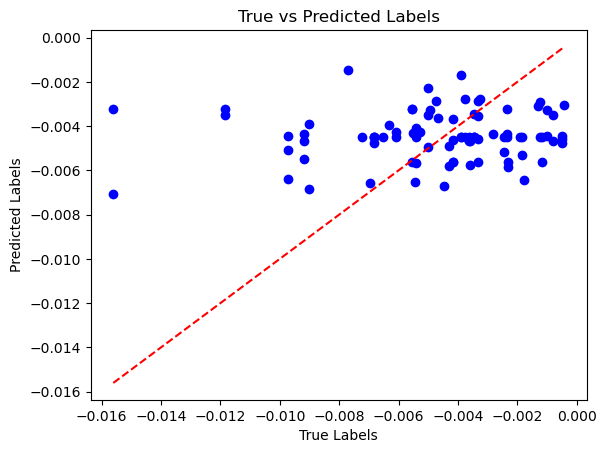

<Figure size 640x480 with 0 Axes>

In [44]:
import tensorflow as tf
import keras

#settings

#test set size
test_ratio=0.25

#batch size
batch_size =1



train_ratio=1-test_ratio
train_size=int(train_ratio*len(corr_list))

features=pair_arr
print(features.shape)
labels=np.array(corr_list)
print(labels.shape)


dataset=tf.data.Dataset.from_tensor_slices((features,labels))
dataset = dataset.shuffle(buffer_size=len(corr_list)//4)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


inp_shape=(n**3+4,n**3)
model = keras.Sequential([
    keras.layers.Flatten(input_shape=inp_shape),
    keras.layers.Dense(2000, activation='softmax'),
    keras.layers.Dense(1,)  
])
print(model.summary())
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='huber',
              metrics=['mean_absolute_error', 'mean_squared_error'])
model.fit(train_dataset,epochs=50)
model.evaluate(test_dataset)

model.save('new.keras')

predictions = model.predict(test_dataset)


import matplotlib as mpl
import matplotlib.pyplot as plt

test_labels = []
for features, labels in test_dataset:
    test_labels.append(labels.numpy())
error=sum([abs((predictions[i]-test_labels[i])/test_labels[i])for i in range(len(predictions))])

test_labels = np.concatenate(test_labels, axis=0)
plt.scatter(test_labels, predictions, c='blue')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')  # Line for y=x
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True vs Predicted Labels')
plt.show()
plt.savefig('useless.png')

In [ ]:
print(predictions)

In [ ]:
"""
import keras_tuner
import keras
from keras.layers import Dense, InputLayer

def build_model(hp):
 
  model = keras.Sequential()
  model.add(InputLayer(shape=inp_shape))
  model.add(keras.layers.Dense(units,activation=acti
        )
    )
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile( optimizer='adam',
        loss='mse',
        metrics=['mae'])
  return model
    
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    directory="/tmp/tb")
    
tuner.search(train_dataset, epochs=50, validation_data=test_dataset)
best_model = tuner.get_best_models()[0]
"""

In [19]:
n_clusters = 3  

def kmeans(X, n_clusters, num_iterations=100):
    centroids = tf.random.uniform([n_clusters, tf.shape(dist_list)[1]])
    for q in range(num_iterations):
        distances = tf.reduce_sum(tf.square(tf.expand_dims(dist_list, axis=1) - centroids), axis=2)
        assignments = tf.argmin(distances, axis=1)
        new_centroids = tf.zeros_like(centroids)
        for i in range(n_clusters):
            mask = tf.cast(assignments == i, tf.float32)
            sum_points = tf.reduce_sum(tf.expand_dims(mask, axis=1) * X, axis=0)
            count = tf.reduce_sum(mask)
            new_centroids = tf.tensor_scatter_nd_update(new_centroids, [[i]], [sum_points / count])
        centroids = new_centroids 


NameError: name 'X' is not defined

[[ 1.00000000e+00 -4.13039000e-03]
 [ 1.00000000e+00 -4.13039000e-03]
 [ 4.44250204e-01 -6.27030000e-04]
 ...
 [ 4.21069212e-01 -6.42776000e-03]
 [ 1.00000000e+00 -7.21726000e-03]
 [ 1.00000000e+00 -7.21726000e-03]]


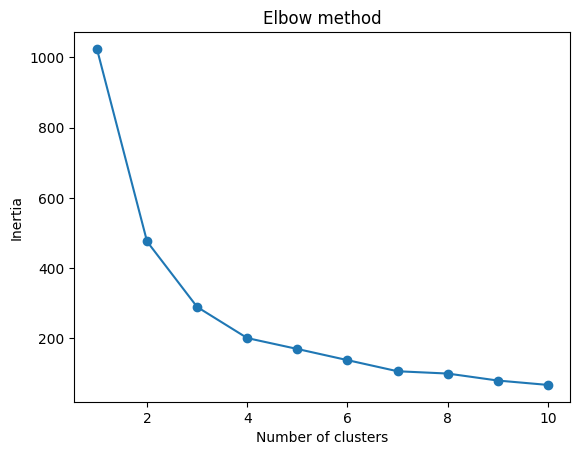

In [62]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



data = np.array(list(zip(dist_list, corr_list)))

data_scaled = StandardScaler().fit_transform(data)
print(data)
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

Silhouette Score for 3 clusters: 0.5521925642720209


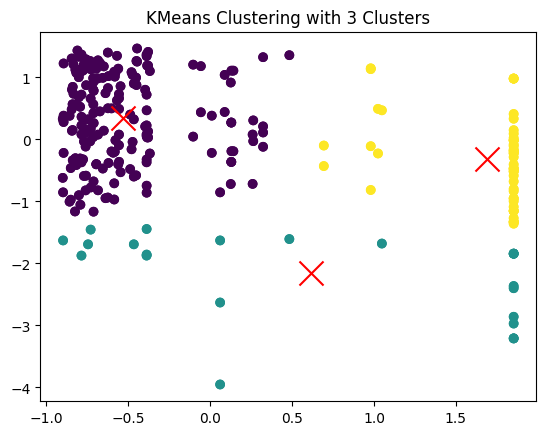

In [67]:
from sklearn.metrics import silhouette_score
kmeans = KMeans(n_clusters=3, random_state=0).fit(data_scaled)

score = silhouette_score(data_scaled, kmeans.labels_)
print(f'Silhouette Score for 3 clusters: {score}')


labels = kmeans.labels_
plt.scatter(data_scaled[:, 0], data_scaled[: ,1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='x')
plt.title(f'KMeans Clustering with 3 Clusters')
plt.show()

In [ ]:

cluster_data = {i: [] for i in range(3)}
cluster_targets = {i: [] for i in range(3)}


for i in range(len(data)):
    cluster_data[labels[i]].append(data_scaled[i])
    cluster_targets[labels[i]].append(target[i])


for key in cluster_data.keys():
    cluster_data[key] = np.array(cluster_data[key])
    cluster_targets[key] = np.array(cluster_targets[key])


In [5]:
import tensorflow as tf
import keras
train_ratio=1-0.2
train_size=int(train_ratio*len(selflab_list))



#self_lab_arr=np.reshape(self_lab_arr,(-1,1))
#self_arr=np.reshape(self_arr,(1,-1))


print(self_arr.shape,self_lab_arr.shape)

self_dataset=tf.data.Dataset.from_tensor_slices((self_arr,self_lab_arr))


self_dataset = self_dataset.shuffle(buffer_size=len(selflab_list)//4)

strain_dataset = self_dataset.take(train_size)
stest_dataset = self_dataset.skip(train_size)
strain_dataset = strain_dataset.batch(1)
stest_dataset = stest_dataset.batch(1)


2024-08-05 13:21:45.889579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:21:46.469116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:21:46.607240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 13:21:47.603357: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 13:21:52.839542: W tensorflow/compiler/tf2

(62, 67) (62,)


I0000 00:00:1722860515.767907    4887 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722860517.652894    4887 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722860517.656856    4887 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722860517.704817    4887 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

/home/stuart/miniconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


I0000 00:00:1722860519.395360    5018 service.cc:146] XLA service 0x77075c005600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722860519.395405    5018 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-08-05 13:21:59.777237: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-05 13:22:00.720123: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0074 
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 0.0017
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 1.5245e-04
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 2.2910e-04


I0000 00:00:1722860522.466113    5018 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 2.3758e-05
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 1.5667e-04
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 3.9243e-04
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 2.5491e-04
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 1.2328e-04
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 4.5632e-05
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 7.0482e-05
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 2.8220e-05
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 2.9898e-05
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 2.6519e-05
Epoch 15/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 2.1828e-04
Epoch 16/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 1.6116e-04
Epoch 17/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 4.5941e-04
Epoch 18/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 1.4449e-

2024-08-05 13:22:04.332388: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


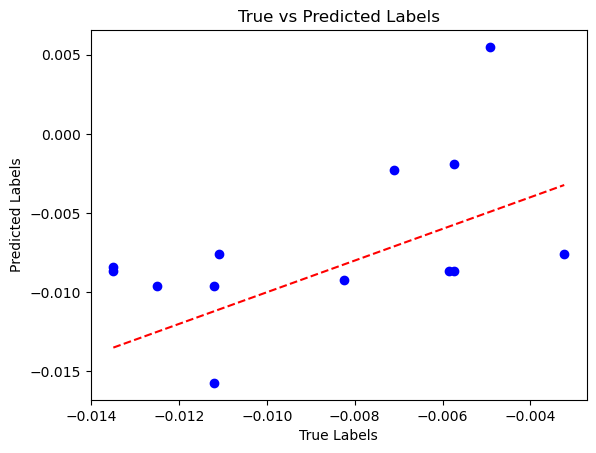

<Figure size 640x480 with 0 Axes>

In [6]:



self_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(67,)),
    keras.layers.Dense(200, activation='relu'),
    keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(1,)  
])

self_model.compile(optimizer='adam',
                   loss='mse')
self_model.fit(strain_dataset,epochs=50)
self_model.evaluate(stest_dataset)
predictions=self_model.predict(stest_dataset)

test_labels = []
for features, labels in stest_dataset:
    test_labels.append(labels.numpy())
error=sum([abs((predictions[i]-test_labels[i])/test_labels[i])for i in range(len(predictions))])

print(error)

test_labels = np.concatenate(test_labels, axis=0)
plt.scatter(test_labels, predictions, c='blue')
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linestyle='--')  # Line for y=x
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('True vs Predicted Labels')
plt.show()
plt.savefig('useless.png',dpi=300)